In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData

画像データの取得

In [5]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [6]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

温度データの取得

In [7]:
data = ThermalData(thermal_img_files)

温度分布の確認（個別）

In [8]:
for k in list(data.temperature.keys())[:10]:
    print(k)    
    v = data.temperature[k]
    filepath = "./hist/hist_" + k
    display.display_distributions(v, filepath, show=False)

63.jpg
189.jpg
77.jpg
162.jpg
176.jpg
88.jpg
200.jpg
201.jpg
188.jpg
76.jpg


温度分布の確認（全体）

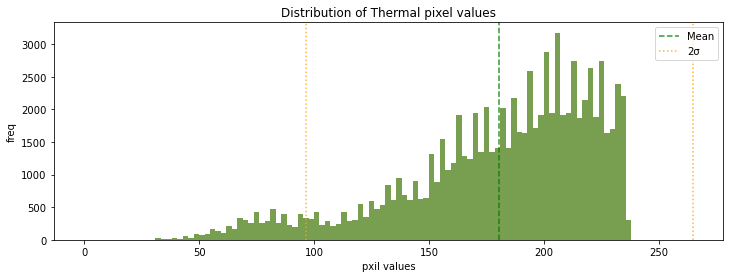

In [9]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

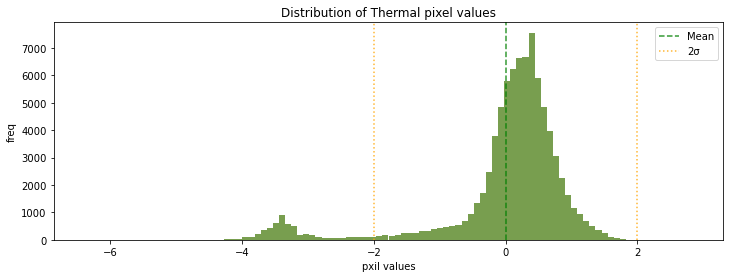

In [10]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

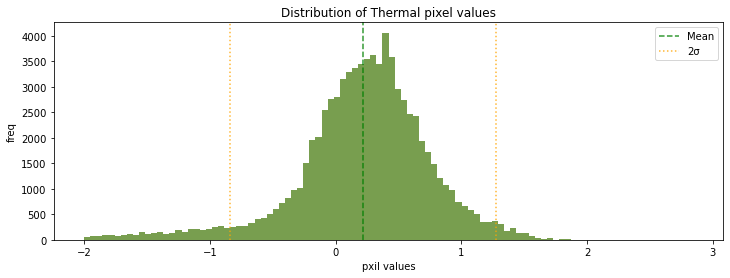

In [11]:
mask = (data.scaled_all_temperature > -2).all(axis=1)
display.display_distributions(data.scaled_all_temperature[mask], 
                              filepath = "hist_masked_scaled_all_themal_data.jpg")

個別画像の分析

In [12]:
#input_file = "72.jpg"
input_file = "12.jpg"
#input_file = "126.jpg"
#input_file = "130.jpg"

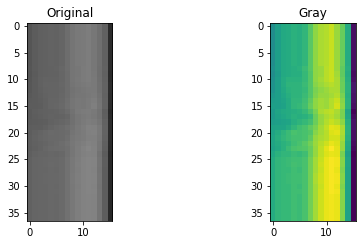

In [13]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(thermal_img_files_gray[input_file])
ax2.set_title("Gray")
plt.show()

クラスタリング

In [14]:
def get_kmeans(inputs, n_clusters=8):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=n_clusters).fit(inputs)
    return model

In [15]:
km = get_kmeans(data.scaled_temperature_with_index[input_file], n_clusters=8)

In [16]:
clusters = []
for n in range(km.n_clusters):
    cluster = np.array(
        [ data.tolist() for label, data in zip(km.labels_,data.temperature[input_file] ) if label==n ]
    )
    clusters.append(cluster)

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

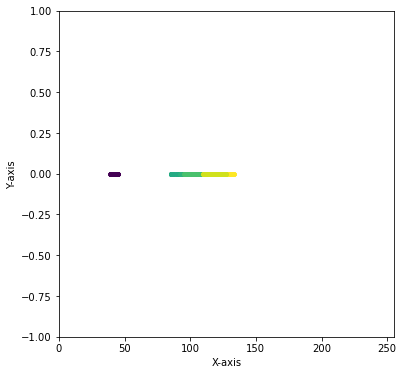

In [18]:
display.plot_2d_scatters_for_clusters(clusters)

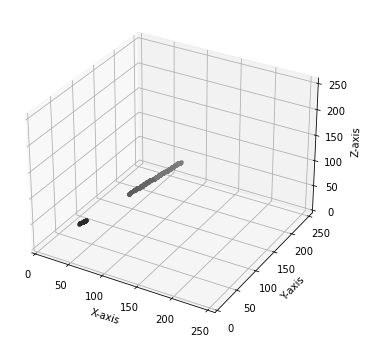

In [19]:
display.plot_3d_scatters_for_clusters(clusters)

In [20]:
centers = np.stack([np.uint8(cluster.mean(axis=0)) for cluster in clusters])

In [21]:
img_clustered = centers[km.labels_]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

In [25]:
from sklearn import preprocessing
mscaler = preprocessing.MinMaxScaler()

In [26]:
colors = cm.viridis(km.labels_)[:, :3]
img_colored = np.uint8(mscaler.fit_transform(colors) * 255)
img_colored = img_colored.reshape(thermal_img_files[input_file].shape)
img_colored  = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)

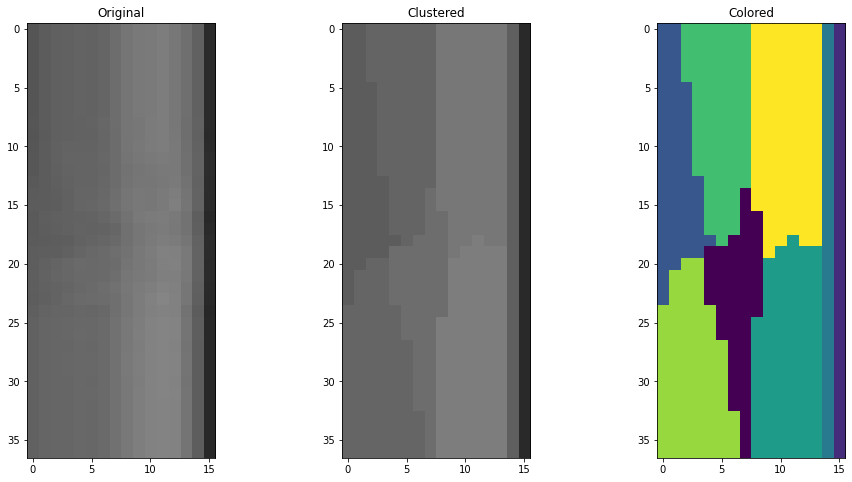

In [27]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(131)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(132)
ax2.imshow(img_clustered)
ax2.set_title("Clustered")
ax3 = fig.add_subplot(133)
ax3.imshow(img_colored)
ax3.set_title("Colored")
plt.show()

In [28]:
mask = data.scaled_temperature[input_file] > -2
mask = mask.reshape(thermal_img_files[input_file].shape)

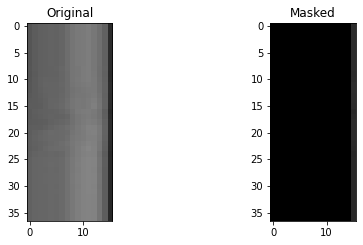

In [29]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(thermal_img_files[input_file]*~mask)
ax2.set_title("Masked")
plt.show()

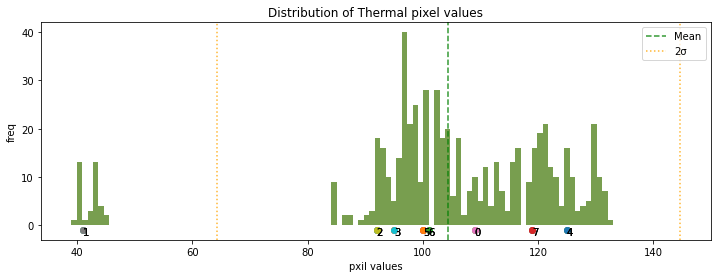

In [30]:
display.display_distributions(data.temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = centers)

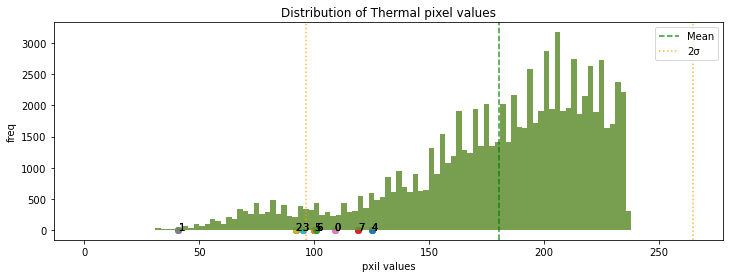

In [31]:
display.display_distributions(data.all_temperature, 
                              filepath = "test.jpg", cluster_centers = centers)

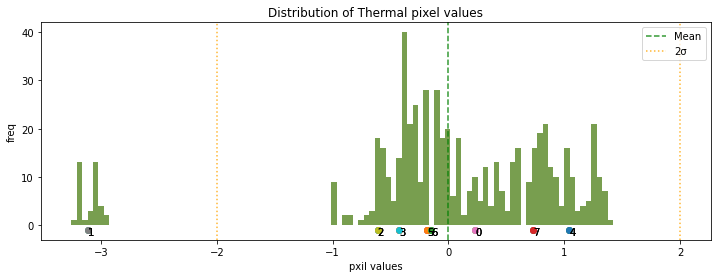

In [35]:
display.display_distributions(data.scaled_temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = km.cluster_centers_[:,:3])

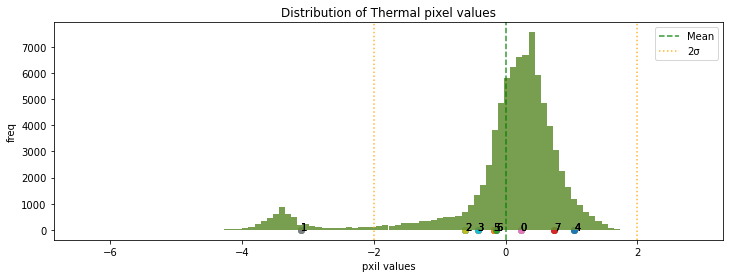

In [36]:
display.display_distributions(data.scaled_all_temperature, 
                              filepath = "test.jpg", cluster_centers = km.cluster_centers_[:,:3])

In [37]:
from sklearn.mixture import GaussianMixture

In [40]:
gmm = GaussianMixture(
    n_components=4, # ["High", "Medium", "Low", "Exceptions"]
    covariance_type='spherical'
).fit(
    data.scaled_all_temperature
)

In [41]:
index2class = { idx:c for idx, c
               in zip(np.argsort(gmm.means_[:, -1])[::-1], ["High", "Medium", "Low", "Exception"]) }

In [42]:
index2class

{0: 'High', 3: 'Medium', 1: 'Low', 2: 'Exception'}

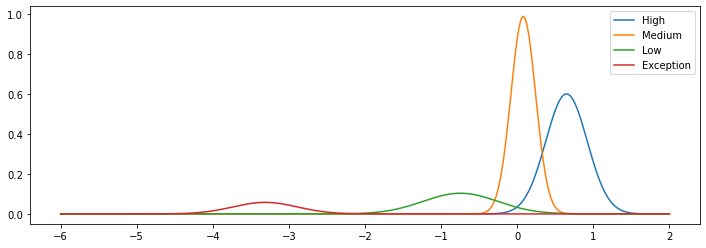

In [43]:
from scipy import stats
fig = plt.figure(figsize=(12,4),facecolor="w")
ax1 = fig.add_subplot(1,1,1)
x = np.linspace(-6, 2, 300)
gd = []
for idx, c in index2class.items():
    gd = stats.norm.pdf(x, gmm.means_[idx, -1], np.sqrt(gmm.covariances_[idx]))
    plt.plot(x, gmm.weights_[idx] * gd, label=c)
plt.legend()
plt.show()

In [45]:
predicted_classes = gmm.predict(km.cluster_centers_[:, :3])

In [46]:
[ index2class[c] for c in predicted_classes ]

['Medium', 'Exception', 'Low', 'Low', 'High', 'Medium', 'Medium', 'High']

In [47]:
# 異常クラス判定

In [48]:
cluster_types = [ index2class[c] for c in predicted_classes ]

In [49]:
cluster_types

['Medium', 'Exception', 'Low', 'Low', 'High', 'Medium', 'Medium', 'High']

In [50]:
def detect_module_type(cluster_types):
    hot_counts = cluster_types.count("High")
    if hot_counts == 1:
        module_type = "Single-Hotspot"
    elif hot_counts >= 2:
        module_type = "Multi-Hotspots"
    else:
        module_type = "Normal"
    return module_type

In [51]:
detect_module_type(cluster_types)

'Multi-Hotspots'

In [ ]:
# 異常タイプの確認テスト

In [ ]:
#pred = get_KMeans_results(scaled_flatten_thermal_data_with_index[input_file])